# Stable Diffusion Sampling Experiments

One of the great things with _Diffusion Models_ (DMs) is that we can tune a bit their results without retraining them. Indeed, their inference process is somewhat an optimization process, and therefore can be tuned at several levels. 

In this notebook, I try to analyze a bit the sampling process of [Stable Diffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion), and derive from this analysis potential small variations (improvements?) of the images generated. 

Notes: 

1. I do not go into details of how diffusion models work here, here are some amazing references for those of you who want to learn more about them:
- [A great blog post from Yang Song](https://yang-song.net/blog/2021/score/) (and the [video](https://www.youtube.com/watch?v=nv-WTeKRLl0&ab_channel=YingzhenLi) from the same author)
- [fastai part2 2022 lesson 9](https://www.youtube.com/watch?t=2697&v=_7rMfsA24Ls&feature=youtu.be&ab_channel=JeremyHoward)
- The paper ["Elucidating the design space of diffusion models"](https://arxiv.org/abs/2206.00364) from Karras et. al., which gives an amazing unifying framework to reason about the different diffusion models

2. Part of the text and code below are taken from this [fastai notebook](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb). Thanks to them for the amazing work done! 

3. I did not put a high emphasis on code quality here, because I wanted to mostly focus on the ideas and intuitions to understand Stable Diffusion. 

## Imports And Utils

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

Let's start by importing the libraries, select a GPU, and load a hf token

In [2]:
# !pip install -Uq diffusers transformers fastcore
import torch
torch.cuda.set_device(1) 
from PIL import Image
from fastcore.all import concat
import torch, logging
from pathlib import Path
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
logging.disable(logging.WARNING)

if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()
from tqdm.auto import tqdm

/home/seb.derhy/anaconda3/envs/sdv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Very useful function to display a grid of images

In [3]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Using Stable Diffusion

In order to always get the same results, we define a seed. 

In [4]:
seed = 123

Part of the prompts were taken from [here](https://mpost.io/best-100-stable-diffusion-prompts-the-most-beautiful-ai-text-to-image-prompts/).

In [18]:

prompts = [
    'portrait photo of an astronaut riding a horse',
    'portrait photo of a handsome businesssman',
    'portrait photo of an asia old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography',
    'portrait photo headshot by mucha, sharp focus, elegant, render, octane, detailed, award winning photography, masterpiece, rim lit'
]


prompts = [
    "The logo of a startup called 'kipod' with a hedgehog",
]

guidance_scale = 7.5
num_inference_steps = 50
device = torch.device("cuda")
num_images_per_prompt = 4

In [19]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

model_id = "stabilityai/stable-diffusion-2-base"

# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 21317.94it/s]


Let's start by running the pipeline "off-the-shelf", without any modification

In [20]:
torch.manual_seed(seed)
images = pipe(prompts, 
             guidance_scale=guidance_scale, 
             num_inference_steps=num_inference_steps, 
             num_images_per_prompt=num_images_per_prompt).images

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


In [21]:
len(images)

4

In [16]:
ref_images = images.copy()

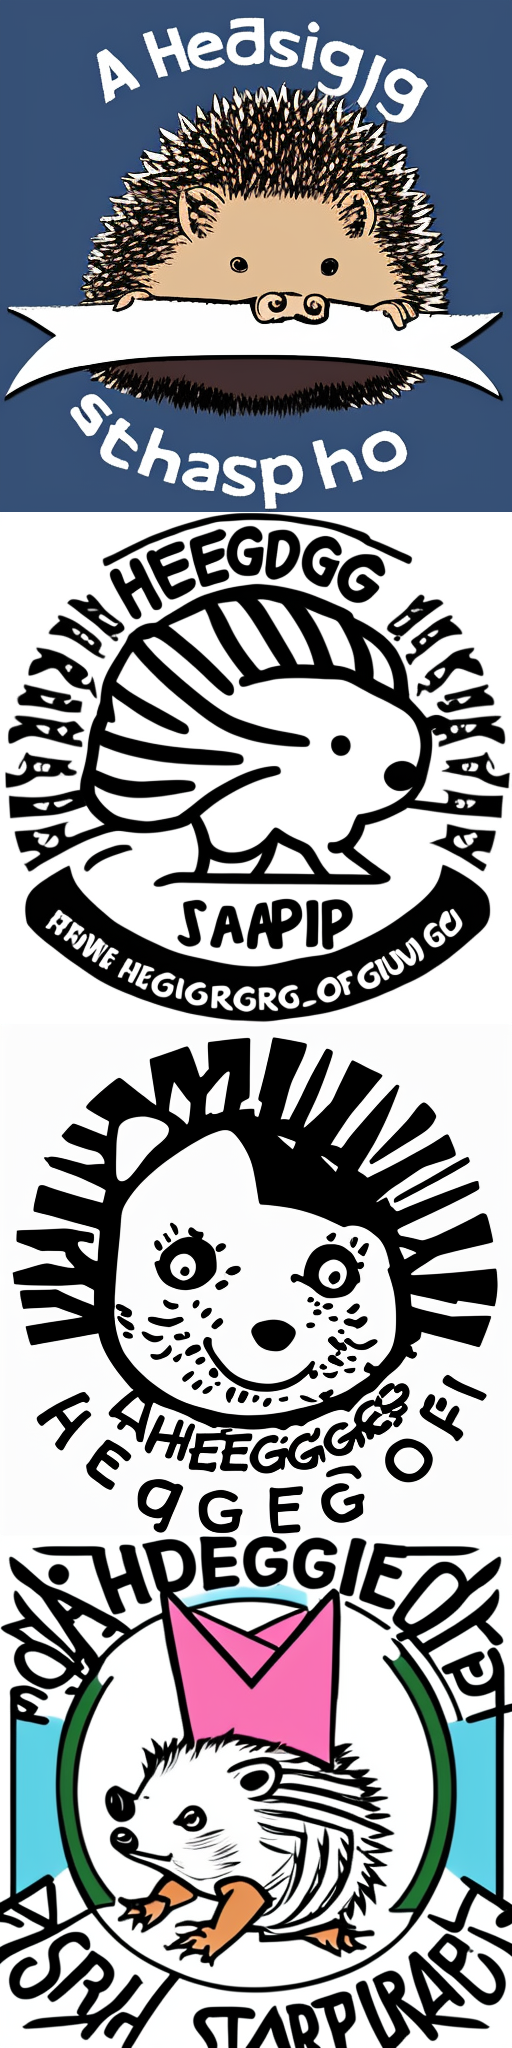

In [17]:
image_grid(ref_images, rows=num_images_per_prompt, cols=len(prompts))

# Reproduce inference loop 

In order to customize the inference loop, the first step is to reimplement it, and add some "backdoors". More specifically, we will add 2 backdoors:
- One that allows for a different update at each iteration
- One that allows for post-processing after the sampling loop has been run

These 2 customization points may look a bit random at this point, but we will see later how they can be useful

In [ ]:
def regular_update(latents, i, t, text_embeddings, do_classifier_free_guidance):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    return latents

In [ ]:
@torch.no_grad()
def my_sd_sampling(prompt=prompts, device=device, 
             guidance_scale=guidance_scale, 
             num_inference_steps=num_inference_steps, 
             num_images_per_prompt=num_images_per_prompt, 
             custom_update=None, post_processing=None, **kwargs):
    
    # 0. Default height and width to unet
    height = pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = pipe.unet.config.sample_size * pipe.vae_scale_factor

    # 1. Check inputs. Raise error if not correct
    pipe.check_inputs(prompt, height, width, callback_steps=1)

    # 2. Define call parameters
    batch_size = 1 if isinstance(prompt, str) else len(prompt)

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # 3. Encode input prompt
    text_embeddings = pipe._encode_prompt(prompt, device, num_images_per_prompt, 
                                          do_classifier_free_guidance, negative_prompt=None)

    # 4. Prepare timesteps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = pipe.scheduler.timesteps

    # 5. Prepare latent variables
    num_channels_latents = pipe.unet.in_channels
    latents = pipe.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        text_embeddings.dtype,
        device,
        generator=None,
        latents=None,
    )
    
    num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
    # 7. Denoising loop
    for i, t in enumerate(pipe.progress_bar(timesteps)):
        if custom_update:
            latents = custom_update(latents, i, t, text_embeddings, do_classifier_free_guidance)
        else:
            latents = regular_update(latents, i, t, text_embeddings, do_classifier_free_guidance)

    if post_processing: ## We are adding here the option of post-processing the final latent outputs
        latents = post_processing(**kwargs)
            
    # 8. Post-processing
    image = pipe.decode_latents(latents)

    # 9. Run safety checker
    image, has_nsfw_concept = pipe.run_safety_checker(image, device, text_embeddings.dtype)

    # 10. Convert to PIL
    images = pipe.numpy_to_pil(image)
    
    return images

In [ ]:
torch.manual_seed(seed)
imgs = my_sd_sampling()

Let's check that our pipeline gives the same results as the original one

In [ ]:
import numpy as np
assert np.sum(np.array(imgs[0])-np.array(ref_images[0]))==0

In [ ]:
# image_grid(ref_images + imgs, rows=2*num_images_per_prompt, cols=len(prompts))

# Log and analyze noise predictions 

Below, we are going to log the 3 noise predictions that are performed at each timestep:
- `noise_pred_uncond` (with just the noisy image as input) 
- `noise_pred_text` (with the noisy image + text encoding as input)
- `noise_pred` (weighted average between them using the guidance_scale parameter)


##  Log the noise predictions

In [ ]:
def update_with_debug_logs(latents, i, t, text_embeddings, do_classifier_free_guidance):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_unconds.append(noise_pred_uncond.detach().cpu()) ## Log the noise unconds results
        noise_conds.append(noise_pred_text.detach().cpu()) ## Log the noise conds results
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        noise_preds.append(noise_pred.detach().cpu())

    # compute the previous noisy sample x_t -> x_t-1
    new_latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    latent_step = new_latents-latents 

    return new_latents

In [ ]:
noise_preds, noise_unconds, noise_conds = [], [], []
torch.manual_seed(seed)
imgs = my_sd_sampling(custom_update=update_with_debug_logs)

In [ ]:
import numpy as np
assert np.sum(np.array(imgs[0])-np.array(ref_images[0]))==0

In [ ]:
# image_grid(ref_images[:len(prompts)] + imgs[:len(prompts)] 
#            + ref_images[len(prompts):] + imgs[len(prompts):], rows=2*num_images_per_prompt, cols=len(prompts))

## Compare the noise norms

One thing we observe from the code above (`noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)`) is that we actually pass the input image twice to the network at each iteration: 


- Once _without_ the conditional text input -> Predict the noise from the noisy image only 
- Once _with_ the conditional text input -> Predict the noise from the noisy image AND the image description's encoding

Since these inputs are a bit different, we expect these 2 passes to predict different noise values (i.e. point towards different real images). However, since both networks are trained to predict noise from a noisy image, we should expect the noise prediction to have approximately the same norm in both cases. 

Let's see if this is true, and let's also compare this norm with the final noise prediction norm.

In [ ]:
noise_preds_norm = [pred.norm() for pred in noise_preds]
noise_unconds_norm = [pred.norm() for pred in noise_unconds]
noise_conds_norm = [pred.norm() for pred in noise_conds]

In [ ]:
plt.scatter(range(num_inference_steps), noise_unconds_norm, c='b', alpha=0.5, label="Unconditional noise pred norm")
plt.scatter(range(num_inference_steps), noise_conds_norm, c='g', alpha=0.5, label="Conditional noise pred norm")
plt.scatter(range(num_inference_steps), noise_preds_norm, c='r', alpha=0.5, label="Final noise pred norm")
plt.legend()

Here we indeed see that the unconditional and conditional noise norms are approximately the same. However, the final noise prediction seems to have a slightly different norm? Why is that?

The answer to this question is in the next line of code:

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`

This line does a weighted average between the conditioned and unconditioned noise prediction, and has therefore ABSOLUTELY NO REASON to have the same norm. 

Does this make sense? Well... In my opinion, not so much, so let's try to re-normalize things :).

# Improve the pipeline with "whole" rescale

NOTE: the idea implemented below was first suggested by [Jeremy Howard](https://twitter.com/jeremyphoward) in this [Twitter thread](https://twitter.com/jeremyphoward/status/1584667612348227584?s=20&t=40IVYJnW8kpdCHbNJYUZWw)

In [ ]:
def update_with_rescale(latents, i, t, text_embeddings, do_classifier_free_guidance):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        noise_pred = noise_pred/noise_pred.norm()*noise_pred_uncond.norm() ### THIS IS THE KEY CHANGE

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    return latents

In [ ]:
torch.manual_seed(seed)
imgs = my_sd_sampling(custom_update=update_with_rescale)

In [ ]:
image_grid(ref_images[:len(prompts)] + imgs[:len(prompts)] 
           + ref_images[len(prompts):] + imgs[len(prompts):], rows=2*num_images_per_prompt, cols=len(prompts))

In [ ]:
ref_images[0]

In [ ]:
imgs[0]

In [ ]:
ref_images[2]

In [ ]:
imgs[2]

Definitely improves the image quality in my opinion!

# Log and analyze latent space trajectory

## Log trajectory

Below, we are going to log the trajectory point at each timestep, so that we can analyze a bit what's happening

In [ ]:
def update_with_debug_logs(latents, i, t, text_embeddings, do_classifier_free_guidance):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    new_latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    latent_step = new_latents-latents 

    # THIS IS THE IMPORTANT LINES --> Log information
    traj_pts_times.append(t.detach().cpu())
    traj_pts_values.append(new_latents.detach().cpu())
    return new_latents

In [ ]:
traj_pts_times, traj_pts_values = [], []
torch.manual_seed(seed)
imgs = my_sd_sampling(custom_update=update_with_debug_logs)

I find the fact that time is moving backward a bit unintuitive, especially for the kind of things we'll do next, so let's reverse it. 

In [ ]:
traj_pts_times[:10]

In [ ]:
traj_pts_times = [999-t for t in traj_pts_times]

## Visualize the trajectory using dimension reduction 

Here we will perform 3 different types of dimension reduction in order to visualize the trajectory
- [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)
- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling)

In these plot, yellow represent the enf of the sampling process, while the purple represents the beginning of the sampling process.

In [ ]:
from sklearn.manifold import TSNE
X = torch.stack(traj_pts_values).view(len(traj_pts_values), -1)
X.shape

In [ ]:
X_lowdim = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
X_lowdim.shape

In [ ]:
plt.scatter(X_lowdim[:, 0], X_lowdim[:, 1], c=traj_pts_times)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_lowdim = pca.fit_transform(X)
X_lowdim.shape

In [ ]:
plt.scatter(X_lowdim[:, 0], X_lowdim[:, 1], c=traj_pts_times)

I personally really like the MDS representation, because it tries to project the data in a way that best preserves distances.

In [ ]:
from sklearn.manifold import MDS
mds = MDS()
X_lowdim = mds.fit_transform(X)
X_lowdim.shape

In [ ]:
plt.scatter(X_lowdim[:, 0], X_lowdim[:, 1], c=traj_pts_times)

We can see that the trajectory is quite smooth!! This is something we'll try to leverage later on. But first let's do some more analysis:

## Analyze the steps length and directions

One interesting way to analyze the trajectory is to look at each step performed in the sampling loop: 
- How big was the step?
- How much is it changing direction in the course of sampling?

In [ ]:
steps = [(traj_pts_values[i+1]-traj_pts_values[i]) for i in range(len(traj_pts_values)-1)]
steps_norms = [step.norm() for step in steps]
steps_unit_vecs = [step/step.norm() for step in steps]
steps_dir_change = [(steps_unit_vecs[i+1]-steps_unit_vecs[i]).norm() for i in range(len(steps_unit_vecs)-1)]

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(18, 12))
axs[0].scatter(traj_pts_times[2:], steps_dir_change)
axs[0].set_title("Direction Changes Strength")
axs[1].scatter(traj_pts_times[1:], steps_norms)
axs[1].set_title("Step Length")

Interestingly, we see that the direction is changing a lot at the end. This tends to make me think that the algorithm overshoots somehow at the end. Let's try to fix this! 

# Prevent overshooting at the end

One very simple way to prevent this convergence overshooting at the end is to only do "part of the way". That is, if the noise prediction says you should do a step size of x, you actually do a step of alpha\*x, where alpha<1. Let's try to implement something like this

In [ ]:
def update_without_overshoot(latents, i, t, text_embeddings, do_classifier_free_guidance):    
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    new_latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    ## THIS IS THE IMPORTANT CHANGE
    if i>=round(0.8*num_inference_steps) and i!=num_inference_steps-1: ## When we get towards the end of the sampling 
        new_latents = latents + 0.85 * (new_latents-latents) #do only 85% of the step supposed to be done.
    return new_latents

In [ ]:
steps_unit_vecs = []
steps_magnitudes = []

In [ ]:
torch.manual_seed(seed)
imgs = my_sd_sampling(custom_update=update_without_overshoot)

In [ ]:
image_grid(ref_images[:len(prompts)] + imgs[:len(prompts)] 
           + ref_images[len(prompts):] + imgs[len(prompts):], rows=2*num_images_per_prompt, cols=len(prompts))

We can do a before/after comparison for one of the images

In [ ]:
ref_images[-2]

In [ ]:
imgs[-2]

The images look definitely sharper, but also a bit noisier unfortunately.

# Trajectory predict

As we saw in the trajectory analysis, the sampling process seems to follow a relatively smooth curve, but the convergence kind of seems "unfinished". So one natural idea would be to regress this trajectory with a polynomial, and then evaluate it at a later time in order to see what the results would have been after a few more iterations (which we don't want to do because we want to maintain the same computational budget).

In [ ]:
def update_with_debug_logs(latents, i, t, text_embeddings, do_classifier_free_guidance):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    new_latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    latent_step = new_latents-latents 

    # Only change we do here in the update is logging the trajectory
    traj_pts_times.append(t.detach().cpu())
    traj_pts_values.append(new_latents.detach().cpu())
    return new_latents

This time, we are going to define and use the post-processing function

In [ ]:
def compute_converged_latent(i_start=0, deg=5, eval_time=999):
    bs = traj_pts_values[0].shape[0]
    pts = torch.stack([pt.flatten() for pt in traj_pts_values])
    times = torch.Tensor([t for t in traj_pts_times])
    times = 999-times # We reverse time as previously
    coefficients, residuals, rank, singular_values, rcond = np.polyfit(times.float().detach().cpu().numpy()[i_start:], 
                                                                   pts.float().detach().cpu().numpy()[i_start:], 
                                                                   deg=deg, full=True)
    y_pred = np.polyval(coefficients, eval_time)
    converged_latents = torch.from_numpy(y_pred).view(bs, 4, 64, 64).half().to(device)
    return converged_latents

In [ ]:
traj_pts_times, traj_pts_values = [], []
torch.manual_seed(seed)
imgs = my_sd_sampling(custom_update=update_with_debug_logs, post_processing=compute_converged_latent, 
                      i_start=0, deg=6, eval_time=1024)

In [ ]:
image_grid(ref_images[:len(prompts)] + imgs[:len(prompts)] 
           + ref_images[len(prompts):] + imgs[len(prompts):], rows=2*num_images_per_prompt, cols=len(prompts))

In [ ]:
ref_images[1]

In [ ]:
imgs[1]

Interestingly, this seems to have mostly an effect on the lighting. Let's try to play a bit with the parameters

In [ ]:
traj_pts_times, traj_pts_values = [], []
torch.manual_seed(seed)
imgs = my_sd_sampling(custom_update=update_with_debug_logs, post_processing=compute_converged_latent, 
                      i_start=0, deg=6, eval_time=1100)

In [ ]:
image_grid(ref_images[:len(prompts)] + imgs[:len(prompts)] 
           + ref_images[len(prompts):] + imgs[len(prompts):], rows=2*num_images_per_prompt, cols=len(prompts))

In [ ]:
traj_pts_times, traj_pts_values = [], []
torch.manual_seed(seed)
imgs = my_sd_sampling(custom_update=update_with_debug_logs, post_processing=compute_converged_latent, 
                      i_start=0, deg=5, eval_time=1050)

In [ ]:
image_grid(ref_images[:len(prompts)] + imgs[:len(prompts)] 
           + ref_images[len(prompts):] + imgs[len(prompts):], rows=2*num_images_per_prompt, cols=len(prompts))

In [ ]:
traj_pts_times, traj_pts_values = [], []
torch.manual_seed(seed)
imgs = my_sd_sampling(custom_update=update_with_debug_logs, post_processing=compute_converged_latent, 
                      i_start=0, deg=4, eval_time=1050)

In [ ]:
image_grid(ref_images[:len(prompts)] + imgs[:len(prompts)] 
           + ref_images[len(prompts):] + imgs[len(prompts):], rows=2*num_images_per_prompt, cols=len(prompts))

Ok, not exactly what we were expecting... This means that this polynomial fit technique is probably not very robust. But maybe it can be used as a new cool form of AI-generated art?

# Everything combined

In [ ]:
def update_with_all_improv(latents, i, t, text_embeddings, do_classifier_free_guidance):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        dir_change = noise_pred_text/noise_pred_text.norm() - noise_pred_uncond/noise_pred_uncond.norm()
        noise_pred = noise_pred_uncond + guidance_scale * dir_change * noise_pred_uncond.norm()
        noise_pred = noise_pred/noise_pred.norm()*noise_pred_uncond.norm()

    # compute the previous noisy sample x_t -> x_t-1
    new_latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    if i>=round(0.8*num_inference_steps) and i!=num_inference_steps-1:
        new_latents = latents + 0.9 * (new_latents-latents)
        
    latent_step = new_latents-latents 
    
    traj_pts_times.append(t.detach().cpu())
    traj_pts_values.append(new_latents.detach().cpu())
    return new_latents

In [ ]:
traj_pts_times, traj_pts_values = [], []
torch.manual_seed(seed)
imgs = my_sd_sampling(custom_update=update_with_all_improv, post_processing=compute_converged_latent, 
                      i_start=0, deg=6, eval_time=1024)

In [ ]:
image_grid(ref_images[:len(prompts)] + imgs[:len(prompts)] 
           + ref_images[len(prompts):] + imgs[len(prompts):], rows=2*num_images_per_prompt, cols=len(prompts))

In [ ]:
ref_images[0]

In [ ]:
imgs[0]

In [ ]:
ref_images[1]

In [ ]:
imgs[1]

In [ ]:
ref_images[2]

In [ ]:
imgs[2]

In [ ]:
ref_images[3]

In [ ]:
imgs[3]

# Conclusion

In this notebook, we made 3 modifications: 
- rescale during the guidance weighted average 
- preventing the overshoot at the end
- smoothing the sampling trajectory using polynomial fit 

Each of those modifications gave slightly different results taken independently. When combined together, they make the images MUCH sharper, which can be a good or bad thing, depending on the effect one wants to get at the end. 

At the end of the day, I think the main takeaway is that understanding and controling the sampling process of diffusion models can have a very important impact, and understanding it can be crucial.